# Import Data

In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...


  0%|          | 0/141 [00:00<?, ?it/s]

Finished loading INFO


100%|██████████| 141/141 [00:37<00:00,  3.77it/s]


In [5]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

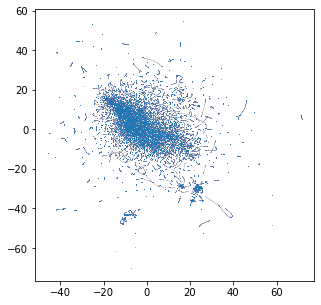

In [6]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_kinematic_embed[:,0], all_kinematic_embed[:,1], s=1, alpha=0.005)
plt.show()

# Quick Overview

In [6]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

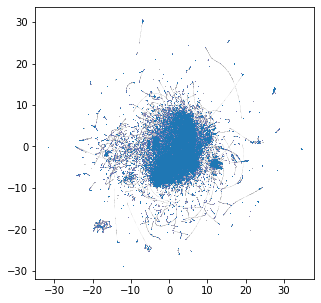

In [7]:
region_x_lim, region_y_lim = (-7,2), (-10,5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=2, alpha=0.006)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

# Power Map on Embedding

In [7]:
import seaborn as sns

In [8]:
max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] # Nyquist Frequency
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1)) # dyadic frequency bins

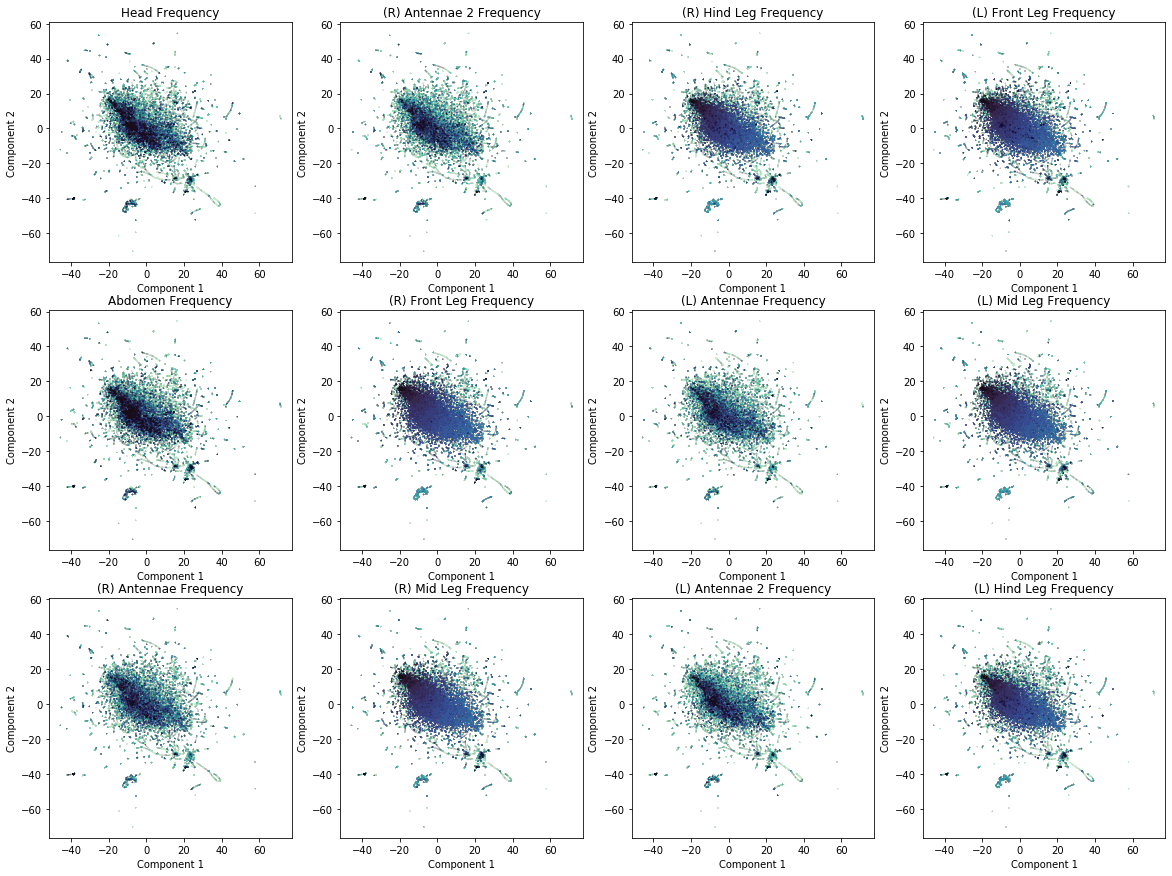

In [9]:
# Figure Information
max_freq_idx = np.argmax(angle_power[:,:,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = matplotlib.colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures
fig, ax = plt.subplots(3,4, figsize=(20,15))
for angle_idx in tqdm(range(12)):
    fig_title = f"{config['angle_labels'][angle_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[:,angle_idx]])

    ax[angle_idx%3, angle_idx//3].scatter(all_kinematic_embed[:,0], all_kinematic_embed[:,1], color=freq_cluster_colors, alpha=0.005, s=1.5)  
    ax[angle_idx%3, angle_idx//3].set(xlabel='Component 1', ylabel='Component 2', title=fig_title) # xlim=region_x_lim, ylim=region_y_lim

plt.show()

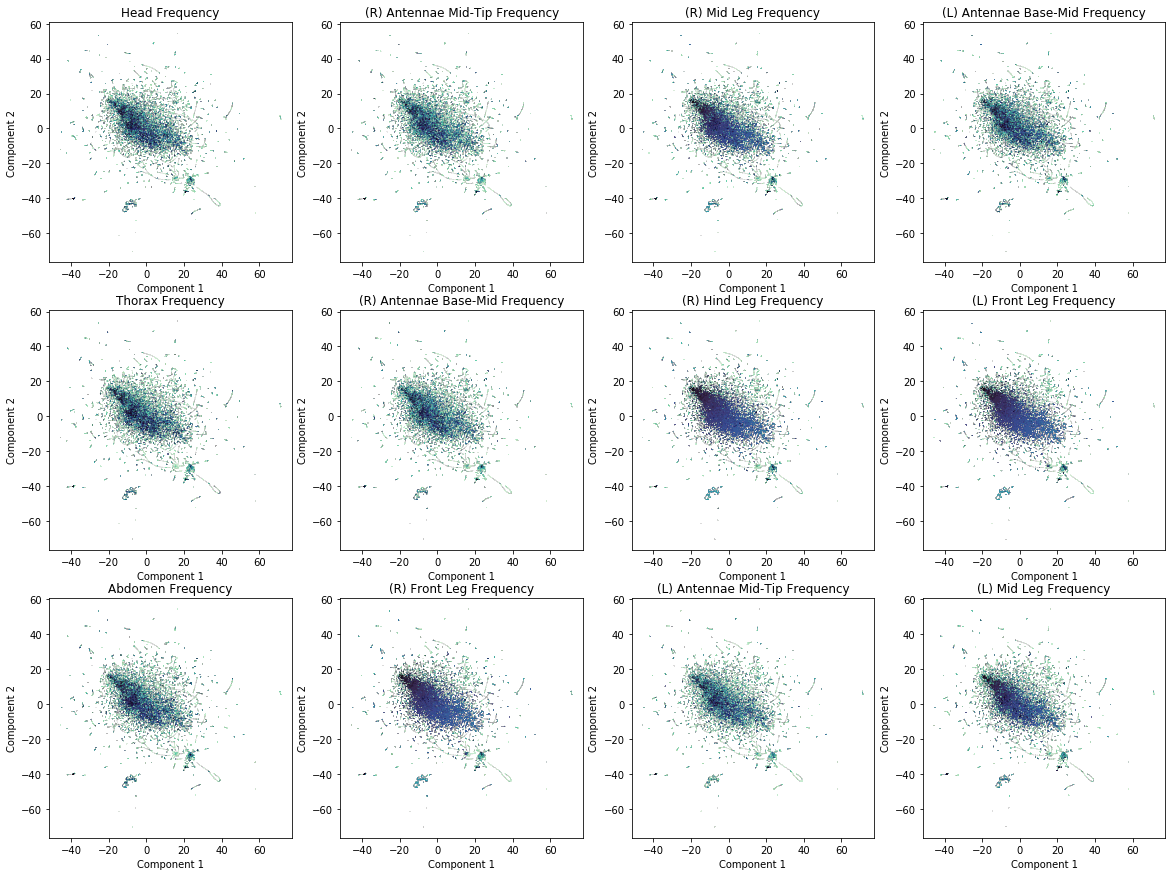

In [18]:
# Figure Information
max_freq_idx = np.argmax(limb_power[:,:,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = matplotlib.colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures
fig, ax = plt.subplots(3,4, figsize=(20,15))
for limb_idx in tqdm(range(12)):
    fig_title = f"{config['limb_labels'][limb_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[:,limb_idx]])

    ax[limb_idx%3, limb_idx//3].scatter(all_kinematic_embed[:,0], all_kinematic_embed[:,1], color=freq_cluster_colors, alpha=0.005, s=0.5)  
    ax[limb_idx%3, limb_idx//3].set(xlabel='Component 1', ylabel='Component 2', title=fig_title) #, xlim=region_x_lim, ylim=region_y_lim
plt.show()

# Checking Kinematic/Postural Scaling

In [14]:
angle_pk_scale = np.max(angle_power, axis=(0,1))/np.max(angles, axis=(0))
limb_pk_scale = np.max(limb_power, axis=(0,1))/np.max(limbs, axis=(0))
adj_angles = angles*angle_pk_scale
adj_limbs = limbs*limb_pk_scale

In [15]:
angle_pk_scale

array([1.52019597, 1.60983968, 0.65329098, 0.70926514, 0.71802813,
       0.72927972, 0.65901491, 0.65735366, 0.65924177, 0.69263601,
       0.8200092 , 0.70475136])

In [16]:
limb_pk_scale

array([2.12811374, 1.92606646, 2.11270275, 2.07522934, 2.08900823,
       2.07736683, 2.06540107, 2.42159542, 2.2445999 , 2.20377784,
       2.22939808, 2.15060295, 2.14910714])

In [19]:
np.max(angle_power, axis=(0,1))

array([4.77436547, 5.05590274, 4.10348394, 4.45507167, 4.51011416,
       4.58078822, 4.1394374 , 4.1290027 , 4.14086234, 4.35061993,
       5.15068282, 4.42671947])

In [21]:
np.max(angles, axis=(0))

array([3.140625, 3.140625, 6.28125 , 6.28125 , 6.28125 , 6.28125 ,
       6.28125 , 6.28125 , 6.28125 , 6.28125 , 6.28125 , 6.28125 ])

In [22]:
limb_power.shape

(1872138, 20, 13)

# Power Spectrogram

In [ ]:
import seaborn as sns
from sklearn.utils import shuffle

from utils.figure import plot_HDBSCAN
from cluster import HDBSCAN
%aimport cluster

In [ ]:
labels, num_clusters, clusterer = HDBSCAN(all_postural_embed, min_cluster_size=3000, min_samples=20, 
                               cluster_selection_epsilon=0, cluster_selection_method="leaf", 
                               memory="memory")
color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

In [ ]:
region_x_lim, region_y_lim = (-23,7), (-5,25)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_postural_embed, labels, color_palette, marker_size=0.2, alpha=0.2, toggle_numbering=True)
plt.show()
# plot_HDBSCAN(ax, all_postural_embed, labels, color_palette, marker_size=0.05, alpha=0.06, toggle_numbering=True, xlim=region_x_lim, ylim=region_y_lim)
# plt.show()

In [ ]:
# matplotlib.rc('font', size=MEDIUM_SIZE)
# matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

num_fr, num_freq, num_angles = angle_power.shape
num_cluster = int(np.max(labels)+1)

max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] 
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))

for i_cluster in range(num_cluster):
    idx_cluster = (labels == i_cluster)
    # plot
    fig, ax = plt.subplots(1,num_angles,figsize=(num_angles*5,2))
    for i_angle in range(num_angles):   
        ax[i_angle].plot(angle_power[idx_cluster,:,i_angle].T, alpha=0.01, c='gray')
        ax[i_angle].plot(np.mean(angle_power[idx_cluster,:,i_angle], axis=0).T, alpha=1, c='red')
        ax[i_angle].set(xlabel='freq', ylabel='power', title=f"PSD of cluster {i_cluster} | {config['angle_labels'][i_angle]}",
                       ylim=[0,1.5], xticks=np.arange(len(freq))[::3], xticklabels=np.round(freq[::3],1))
    plt.show()

In [ ]:
num_fr, num_freq, num_limbs = limb_power.shape
num_cluster = int(np.max(labels)+1)

max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] 
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))

for i_cluster in range(num_cluster):
    idx_cluster = (labels == i_cluster)
    # plot
    fig, ax = plt.subplots(1,num_limbs,figsize=(num_limbs*5,2))
    for i_limb in range(num_limbs):
        ax[i_limb].plot(limb_power[idx_cluster,:,i_limb].T, alpha=0.01, c='gray')
        ax[i_limb].plot(np.mean(limb_power[idx_cluster,:,i_limb], axis=0).T, alpha=1, c='red')
        ax[i_limb].set(xlabel='freq', ylabel='power', title=f"PSD of cluster {i_cluster} | {config['limb_labels'][i_limb]}",
                       ylim=[0,1.5], xticks=np.arange(len(freq))[::3], xticklabels=np.round(freq[::3],1))
    plt.show()